In [18]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TEST_NAME = "mag_test_3"

dt = 1/960

GRAVITY = 9.80665
RAD_TO_DEG = 180 / math.pi
DEG_TO_RAD = math.pi / 180

In [19]:
# read test params from CSVP
csvp = open(f"data/{TEST_NAME}.csvp")

# create params array
params = np.array([eval(line) for line in csvp])

print(params)

[   1 3813    0  300    0    1    0  960   96   16 2000   92   92   63
   63   14   14   86   86    0    0    0    0    0    0    0    0    0
    0    0    0]


In [20]:
# load saved mag offsets (this approach isn't being used right now,
# since min/max averaged offsets are recalculated for each data set)

# read mag offsets from file
offsets_dat = open(f"data/mag_offsets.dat")

# create mag offsets array
mag_offsets = np.array([eval(line) for line in offsets_dat])

In [21]:
# read data from CSV (MagX and MagY are flipped to align mag axes to accel axes)
data = pd.read_csv(f"data/{TEST_NAME}.csv", names=["AccelX", "AccelY", "AccelZ", "GyroX", "GyroY", "GyroZ", "MagY", "MagX", "MagZ"], index_col=False)

sample_rate = params[7]

# add time axis to data set
time = np.arange(0, len(data)/sample_rate, 1/sample_rate)
data.insert(0, "Time", time)

# sign data
data = data.applymap(lambda x: x-65535 if x > 32767 else x)

# apply accel sensitivity
acc_cols = ["AccelX", "AccelY", "AccelZ"]
acc_sens = params[9]
data[acc_cols] = data[acc_cols].applymap(lambda x: x * acc_sens * GRAVITY / 32768)

# apply gyro sensitivity
gyro_cols = ["GyroX", "GyroY", "GyroZ"]
gyro_sens = params[10]
data[gyro_cols] = data[gyro_cols].applymap(lambda x: x * gyro_sens / 32768)

# apply mag sensitivity
mag_cols = ["MagY", "MagX", "MagZ"]
mag_sens = 4800
data[mag_cols] = data[mag_cols].applymap(lambda x: x * mag_sens / 8192)

# invert X and Y mag axes to align with accel axes
data[["MagX", "MagY"]] = -data[["MagX", "MagY"]]

# FIXME copy for debugging, remove later
original_mag_data = data[mag_cols].dropna()

# calculate offsets for each sensor (first 0.5s of data)
acc_offsets = data[acc_cols].head(480).mean()
gyro_offsets = data[gyro_cols].head(480).mean()
#mag_offsets = data[mag_cols].mean()

# min/max method (no longer being used)
#mag_offsets = (data[mag_cols].max() + data[mag_cols].min()) / 2
# for i, axis in enumerate(mag_cols):
#     data[axis] = data[axis].map(lambda x: x - mag_offsets[i])

# apply offsets to gyroscope (remove sensor bias)
for i, axis in enumerate(gyro_cols):
    data[axis] = data[axis].map(lambda x: x - gyro_offsets[i])

# create new mag dataframe by removing all NaNs
mag_data = data[mag_cols + ["Time"]].dropna()

# for some reason, the first mag data point is always erroneous, so remove it
mag_data = mag_data.iloc[1:]

In [22]:
def show_plot(title=""):
    '''Utility method to graph a plot with grid lines, a legend, and a title.'''
    plt.title(title)
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.legend()
    plt.show()

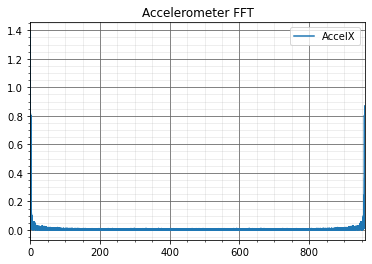

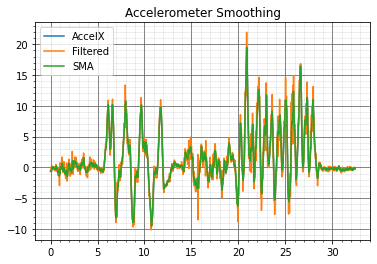

In [23]:
# FFT analysis of accelerometer
# (not currently being used, experimental)
import scipy.signal

# calculate fft for AccelX
fourierTransform = np.fft.fft(data["AccelX"])/len(data["AccelX"])

tpCount = len(data["AccelX"])
values = np.arange(tpCount)
timePeriod = tpCount/sample_rate
frequencies = values/timePeriod

plt.plot(frequencies, abs(fourierTransform), label="AccelX")

# display the plot
plt.xlim(0,960)
show_plot("Accelerometer FFT")

# normalized cutoff frequency = cutoff frequency / (2 * sample rate)
ORDER = 10
# 959.93838386
CUTOFF_FREQ = 100
NORM_CUTOFF_FREQ = CUTOFF_FREQ / (2 * 960)

# Butterworth filter
num_coeffs, denom_coeffs = scipy.signal.butter(ORDER, NORM_CUTOFF_FREQ)
filtered_data = scipy.signal.lfilter(num_coeffs, denom_coeffs, data["AccelX"])

# simple moving average
rolling_data = data[acc_cols].rolling(window=100).mean().fillna(data[acc_cols].iloc[49])

# apply simple moving average
data[acc_cols] = rolling_data

plt.plot(data["Time"], data["AccelX"], label="AccelX")
plt.plot(data["Time"], filtered_data, label="Filtered")
plt.plot(data["Time"], rolling_data["AccelX"], label="SMA")
show_plot("Accelerometer Smoothing")

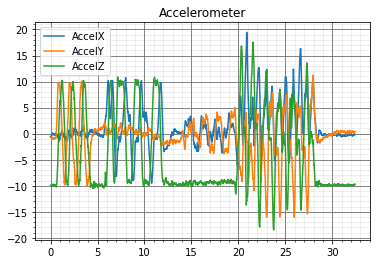

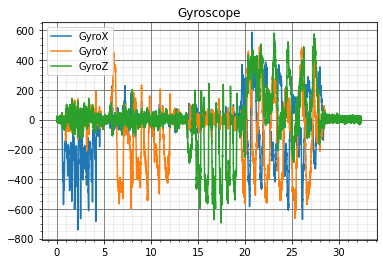

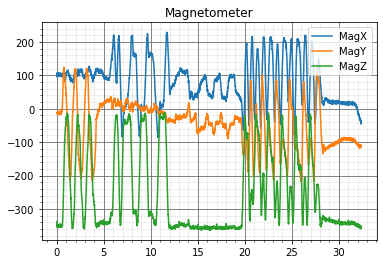

In [24]:
# plot acceleration
plt.plot(data["Time"], data["AccelX"], label="AccelX")
plt.plot(data["Time"], data["AccelY"], label="AccelY")
plt.plot(data["Time"], data["AccelZ"], label="AccelZ")
show_plot("Accelerometer")

# plot gyroscope
plt.plot(data["Time"], data["GyroX"], label="GyroX")
plt.plot(data["Time"], data["GyroY"], label="GyroY")
plt.plot(data["Time"], data["GyroZ"], label="GyroZ")
show_plot("Gyroscope")

# plot magnetometer
plt.plot(mag_data["Time"], mag_data["MagX"], label="MagX")
plt.plot(mag_data["Time"], mag_data["MagY"], label="MagY")
plt.plot(mag_data["Time"], mag_data["MagZ"], label="MagZ")
show_plot("Magnetometer")

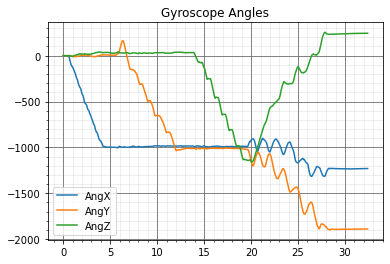

In [25]:
from scipy import integrate

# calculate angles from gyroscope
ang_x = integrate.cumtrapz(y=data["GyroX"], x=data["Time"], initial=0)
ang_y = integrate.cumtrapz(y=data["GyroY"], x=data["Time"], initial=0)
ang_z = integrate.cumtrapz(y=data["GyroZ"], x=data["Time"], initial=0)

# plot gyroscope angles
plt.plot(data["Time"], ang_x, label="AngX")
plt.plot(data["Time"], ang_y, label="AngY")
plt.plot(data["Time"], ang_z, label="AngZ")
show_plot("Gyroscope Angles")

In [26]:
# least squares ellipse fitting
# from https://www.hep.princeton.edu//mumu/target/Yan/ellipse_fit.pdf
#
# (*) denotes tensor product,
# @ denotes matrix multiplication
def ellipse_fit(x_data, y_data):
    # create x and y vectors
    x = np.array(x_data)
    y = np.array(y_data)

    # X = [x (*) x, x (*) y, y (*) y, x, y]
    #  (transpose to account for x and y not being column vectors)
    X = np.array([np.multiply(x, x), np.multiply(x, y), np.multiply(y, y), x, y]).T

    # create n-dimensional column vector filled with 1s
    ones = np.c_[[1] * len(x)]

    # calculate coefficients [A,B,C,D,E] where:
    # Ax^2 + Bxy + Cy^2 + Dx + Ey = 1
    beta = (np.linalg.inv(X.T @ X) @ X.T) @ ones
    return beta

# fit data to 3D ellipsoid
# from: https://teslabs.com/articles/magnetometer-calibration/
def ellipsoid_fit(s):
    print(s)

    # D (samples)
    D = np.array([s[0]**2., s[1]**2., s[2]**2.,
                    2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
                    2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

    # S, S_11, S_12, S_21, S_22 (eq. 11)
    S = np.dot(D, D.T)
    S_11 = S[:6,:6]
    S_12 = S[:6,6:]
    S_21 = S[6:,:6]
    S_22 = S[6:,6:]

    # C (Eq. 8, k=4)
    C = np.array([[-1,  1,  1,  0,  0,  0],
                  [ 1, -1,  1,  0,  0,  0],
                  [ 1,  1, -1,  0,  0,  0],
                  [ 0,  0,  0, -4,  0,  0],
                  [ 0,  0,  0,  0, -4,  0],
                  [ 0,  0,  0,  0,  0, -4]])

    # v_1 (eq. 15, solution)
    E = np.dot(np.linalg.inv(C),
                S_11 - np.dot(S_12, np.dot(np.linalg.inv(S_22), S_21)))

    E_w, E_v = np.linalg.eig(E)

    v_1 = E_v[:, np.argmax(E_w)]
    if v_1[0] < 0: v_1 = -v_1

    # v_2 (eq. 13, solution)
    v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

    # quadric-form parameters
    M = np.array([[v_1[0], v_1[3], v_1[4]],
                  [v_1[3], v_1[1], v_1[5]],
                  [v_1[4], v_1[5], v_1[2]]])

    n = np.array([[v_2[0]],
                  [v_2[1]],
                  [v_2[2]]])

    d = v_2[3]

    return M, n, d

In [27]:
# magnetometer helper functions
def draw_mag_sphere(x_data, y_data, z_data):
    ax.scatter(x_data, y_data, z_data)
    limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
    ax.set_box_aspect(np.ptp(limits, axis=1))
    ax.set_xlabel("Mag X")
    ax.set_ylabel("Mag Y")
    ax.set_zlabel("Mag Z")

def draw_sphere(r=1, c=(0,0,0)):
    '''
    Draws a wireframe sphere in a 3D plot.
    By default, this function draws a unit sphere
    (a sphere with a radius of 1 and centered at the origin).
    '''
    u = np.linspace(0, np.pi, 30)
    v = np.linspace(0, 2 * np.pi, 30)
    x = np.outer(np.sin(u), np.sin(v))
    y = np.outer(np.sin(u), np.cos(v))
    z = np.outer(np.cos(u), np.ones_like(v))
    ax.plot_wireframe(c[0]+r*x, c[1]+r*y, c[2]+r*z, color="r", alpha=0.25)

[[  -0.         -11.71875    -13.4765625 ... -109.5703125 -109.5703125
  -115.4296875]
 [  -0.          96.6796875  107.8125    ...  -40.4296875  -40.4296875
   -40.4296875]
 [   0.        -336.9140625 -349.21875   ... -355.078125  -351.5625
  -355.078125 ]]
[[ 0.58199407 -0.02652191 -0.0135197 ]
 [-0.02652191  0.62160986  0.00585611]
 [-0.0135197   0.00585611  0.52341533]] [[ 24.26603767]
 [-48.18549193]
 [ 97.85216214]] 6658.0282395345075


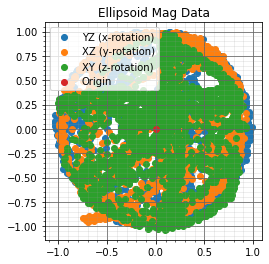

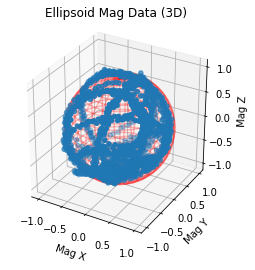

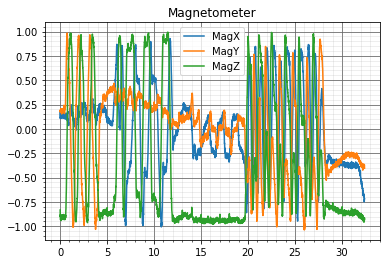

In [28]:
# ellipsoid fit magnetometer calibration
# (from https://teslabs.com/articles/magnetometer-calibration/)

from scipy.linalg import sqrtm

# calculate ellipsoid for data
s = np.array(original_mag_data[mag_cols]).T
M, n, d = ellipsoid_fit(s)

'''
# Saved parameters (don't work):
# ==============================

M = np.array([[ 0.58199407, -0.02652191, -0.0135197],
              [-0.02652191,   0.62160986,  0.00585611],
              [-0.0135197,    0.00585611,  0.52341533]])

n = np.array([[ 24.26603767],
            [-48.18549193],
            [97.85216214]])

d = 6658.0282395345075
'''

print(M, n, d)

# calculate calibration parameters for:
# h_m = A @ h + b where h = A^-1 @ (h_m - b)
M_1 = np.linalg.inv(M)
b = -np.dot(M_1, n)
A_1 = np.real(1 / np.sqrt(np.dot(n.T, np.dot(M_1, n)) - d) * sqrtm(M))

# calculate h = A^-1 @ (h_m - b)
def calibrate_mag(row):
    res = A_1 @ (np.c_[row] - b)
    return res.flatten().tolist()

# calibrate magnetometer
mag_data[mag_cols] = mag_data[mag_cols].apply(calibrate_mag, axis=1, result_type='expand')

# plot x-axis rotation (MagY, MagZ)
plt.scatter(mag_data["MagY"], mag_data["MagZ"], label="YZ (x-rotation)")

# plot y-axis rotation (MagX, MagZ)
plt.scatter(mag_data["MagX"], mag_data["MagZ"], label="XZ (y-rotation)")

# plot z-axis rotation (MagX, MagY)
plt.scatter(mag_data["MagX"], mag_data["MagY"], label="XY (z-rotation)")

# plot origin (0,0)
plt.scatter([0], [0], label="Origin")

# display the plot
plt.axis("square")
show_plot("Ellipsoid Mag Data")

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# 3D plot of mag data
draw_mag_sphere(mag_data["MagX"], mag_data["MagY"], mag_data["MagZ"])
draw_sphere()
plt.title("Ellipsoid Mag Data (3D)")
plt.show()

# plot magnetometer
plt.plot(mag_data["Time"], mag_data["MagX"], label="MagX")
plt.plot(mag_data["Time"], mag_data["MagY"], label="MagY")
plt.plot(mag_data["Time"], mag_data["MagZ"], label="MagZ")
show_plot("Magnetometer")

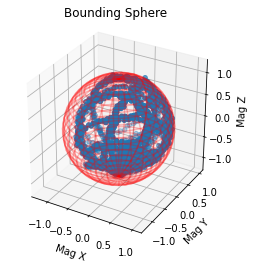

In [29]:
# bounding sphere test (EXPERIMENTAL)
import miniball

# calculate 100% bounding sphere
C, r2 = miniball.get_bounding_ball(mag_data[mag_cols].to_numpy())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# draw 100% bounding sphere
draw_mag_sphere(mag_data["MagX"], mag_data["MagY"], mag_data["MagZ"])
draw_sphere(math.sqrt(r2), C)
plt.title("Bounding Sphere")
plt.show()

<ipython-input-30-fe3f17288c6e>:15: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, A*x**2 + B*x*y + C*y**2 + D*x + E*y, [0])


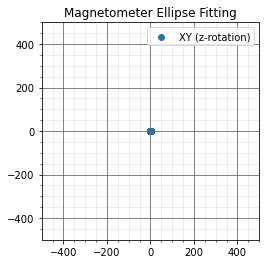

In [30]:
# ellipse fitting test (z-axis)
# (NOT IN USE)

# plot z-axis rotation (MagX, MagY)
plt.scatter(mag_data["MagX"], mag_data["MagY"], label="XY (z-rotation)")
plt.plot()

# calculate coefficients for ellipse fitting
A,B,C,D,E = ellipse_fit(mag_data["MagX"], mag_data["MagY"])

x = np.linspace(-500, 500, 1000)
y = np.linspace(-500, 500, 1000)
x, y = np.meshgrid(x, y)

plt.contour(x, y, A*x**2 + B*x*y + C*y**2 + D*x + E*y, [0])

# display the plot
plt.axis("square")
show_plot("Magnetometer Ellipse Fitting")

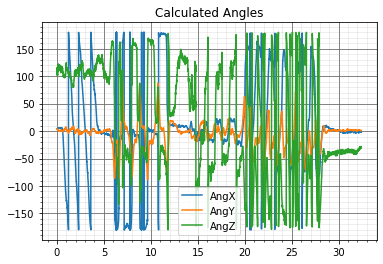

In [31]:
# OLD: calculate angles from accelerometer
# acc_ang_x = np.arctan2(-data["AccelY"], -data["AccelZ"]) * RAD_TO_DEG
# acc_ang_y = np.arctan2(-data["AccelX"], np.sqrt(data["AccelY"]**2 + data["AccelZ"]**2)) * RAD_TO_DEG

# better angle calculation from accelerometer
# (from https://docplayer.net/23187793-Tilt-sensing-using-a-three-axis-accelerometer.html)

# value dictated by paper, either 0.01 or 0.1
MU = 0.01

# calculate better angles from accelerometer
# TODO: added 2 negatives to acc_ang_x, doesn't work without it: why?
acc_ang_x = np.arctan2(-data["AccelY"], -np.sign(data["AccelZ"]) * np.sqrt(data["AccelZ"]**2 + MU * data["AccelX"]**2))
acc_ang_y = np.arctan2(-data["AccelX"], np.sqrt(data["AccelY"]**2 + data["AccelZ"]**2))

# calculate magnetometer + accelerometer parameters
M_x = mag_data["MagX"] * np.cos(acc_ang_y) + mag_data["MagZ"] * np.sin(acc_ang_y)
M_y = mag_data["MagX"] * np.sin(acc_ang_x) * np.sin(acc_ang_y) + mag_data["MagY"] * np.cos(acc_ang_x) - mag_data["MagZ"] * np.sin(acc_ang_x) * np.cos(acc_ang_y)

# remove NaNs from mag params
M_x = M_x[~np.isnan(M_x)]
M_y = M_y[~np.isnan(M_y)]

# calculate z-angle (yaw) from accelerometer & magnetometer
mag_ang_z = np.arctan2(M_y, -M_x)

# convert all angles to degrees
acc_ang_x *= RAD_TO_DEG;
acc_ang_y *= RAD_TO_DEG;
mag_ang_z *= RAD_TO_DEG;

# plot accelerometer angles
plt.plot(data["Time"], acc_ang_x, label="AngX")
plt.plot(data["Time"], acc_ang_y, label="AngY")

# plot mag+accel z-axis angle
plt.plot(mag_data["Time"], mag_ang_z, label="AngZ")

# display the plot
show_plot("Calculated Angles")

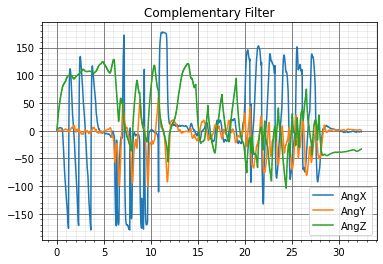

In [32]:
# complementary filter
HP_weight = 0.98
LP_weight = 0.02

# create empty array w/ 3 axes
# set first elements to 0 (will be removed)
cf_ang = [[0],[0],[0]]

# group all axes of calculated angles together
gyro_ang = np.array([data["GyroX"].to_numpy(), data["GyroY"].to_numpy(), data["GyroZ"].to_numpy()])
calc_ang = np.array([acc_ang_x, acc_ang_y, mag_ang_z], dtype=object)

# pair the calculated arrays for each axis together and loop
for i, (gyro_arr, calc_arr) in enumerate(zip(gyro_ang, calc_ang)):

    # pair the gyro & calc samples together and loop
    for j, (gyro, calc) in enumerate(zip(gyro_arr, calc_arr)):

        cf_ang_prev = cf_ang[i][-1]
        cf_ang_samp = HP_weight * (cf_ang_prev + gyro * dt) + LP_weight * calc
        cf_ang[i].append(cf_ang_samp)

        # if this is the magnetometer axis,
        # repeat sample 9x to ensure it lines up with accel/gyro
        if i == 2:
            for _ in range(9):
                cf_ang[i].append(cf_ang_samp)

# since accel/gyro can have additional samples past 10 x mag,
# repeat the last sample to line up mag axis w/ accel/gyro
num_extra = len(cf_ang[0]) - len(cf_ang[2])
for _ in range(num_extra):
    cf_ang[2].append(cf_ang[2][-1])

# remove initial 0 values
for axis in cf_ang: del axis[0]

plt.plot(data["Time"], cf_ang[0], label="AngX")
plt.plot(data["Time"], cf_ang[1], label="AngY")
plt.plot(data["Time"], cf_ang[2], label="AngZ")

# display the plot
show_plot("Complementary Filter")

In [33]:
import csv

# save angle data as CSV
with open("out.csv", "w", newline="") as csvfile:
    
    # define CSV writer
    writer = csv.writer(csvfile, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    # loop over each row of (x,y,z),
    # and write each line to CSV
    for row in zip(*cf_ang):
        writer.writerow(row)